## 3.1 Simple CNN
이번 실습은 classifier 역할을 하는 DNN 앞에, feature extractor 역할을 하는 Covolution layer를 및 Maxplling layer를 덧붙여

CNN 모델을 만들고 학습시켜 볼 것이다.

In [1]:
from keras.utils import np_utils
from keras import datasets
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## (1) 데이터셋

In [2]:
(X_train, Y_train),(X_test, Y_test) = datasets.mnist.load_data()
print(X_train.shape, Y_train.shape)

(60000, 28, 28) (60000,)


MNIST 데이터는 load했을 때 channel이 없기 때문에 channel을 추가하여 3차원 이미지로 바꿔주어야 함(batch차원 제외)

Tensorflow base에서는 (batch, image row, image column, image channel)으로 이미지를 학습

Teano base에서는 (batch, image channel, image row, image column)으로 이미지를 학습

backend.image_data_format()로 channel의 위치를 확인하고 reshape


In [3]:
from keras import backend
backend.image_data_format()

'channels_last'

In [4]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)

print(X_train.shape, Y_train.shape)

n_in = X_train.shape[1:]
n_out = Y_train.shape[-1]

(60000, 28, 28, 1) (60000, 10)


## (2) 모델링

<사용되는 Layer>

`Conv2D` : 이미지에 필터의 파라미터를 convolution 연산하여 다음 layer로 전달

https://keras.io/layers/convolutional/#conv2d

`MaxPooling2D` : 필터에 겹치는 값들 중 가장 큰 값만 다음 layer로 전달

https://keras.io/layers/pooling/#maxpooling2d

`BatchNormalization` : activation에 입력되기 전 데이터를 가우시안 분포로 정규화하여 학습 안정화

https://keras.io/layers/normalization/#batchnormalization

`Dropout` : 일부 뉴런을 drop하여 overfitting을 방지

https://keras.io/layers/core/#dropout
    
보통 batchnormalization, dropout은 동시에 사용하지 않음

`Flatten` : 다차원 tensor를 1차원 벡터로 변환

https://keras.io/layers/core/#flatten

In [5]:
from keras.layers import Flatten, BatchNormalization, Dropout, ReLU
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

In [6]:
def CNN(n_in, n_out):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=n_in))
    model.add(Conv2D(32, (3, 3), padding='same',strides=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_out, activation='softmax'))
    return model

def CNN_BN(n_in, n_out):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same', input_shape=n_in))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(32, (3, 3), padding='same',strides=(2, 2)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(n_out, activation='softmax'))
    return model

In [7]:
model=CNN_BN(n_in, n_out)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 16)        64        
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 7, 7, 32)          0

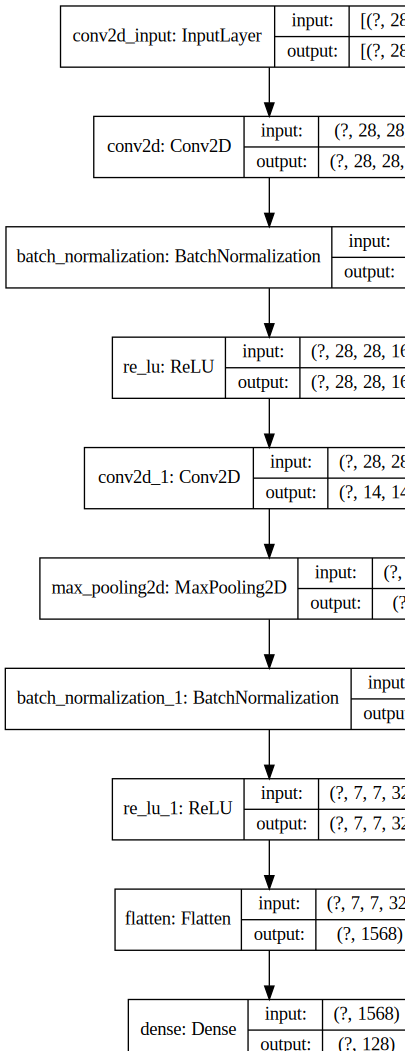

In [8]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## (3) 모델의 학습과정 설정

optimizer에 문자열 대신에 파라미터를 수정한 optimizer를 입력할 수 있음

https://keras.io/optimizers/#adam

In [9]:
from keras.optimizers import Adam

In [10]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=1e-6, epsilon=None, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

## (4) 모델 학습시키기

In [11]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_split=0.2)

Epoch 1/20
375/375 [==============================] - 18s 48ms/step - loss: 0.1579 - accuracy: 0.9568 - val_loss: 0.0759 - val_accuracy: 0.9773
Epoch 2/20
375/375 [==============================] - 18s 47ms/step - loss: 0.0423 - accuracy: 0.9882 - val_loss: 0.0656 - val_accuracy: 0.9788
Epoch 3/20
375/375 [==============================] - 18s 47ms/step - loss: 0.0254 - accuracy: 0.9926 - val_loss: 0.0439 - val_accuracy: 0.9860
Epoch 4/20
375/375 [==============================] - 18s 47ms/step - loss: 0.0160 - accuracy: 0.9960 - val_loss: 0.0496 - val_accuracy: 0.9852
Epoch 5/20
375/375 [==============================] - 17s 47ms/step - loss: 0.0109 - accuracy: 0.9975 - val_loss: 0.0458 - val_accuracy: 0.9863
Epoch 6/20
375/375 [==============================] - 18s 48ms/step - loss: 0.0075 - accuracy: 0.9985 - val_loss: 0.0474 - val_accuracy: 0.9848
Epoch 7/20
375/375 [==============================] - 18s 47ms/step - loss: 0.0049 - accuracy: 0.9992 - val_loss: 0.0518 - val_accuracy:

## (5) 모델 평가하기

In [12]:
loss_and_accuracy = model.evaluate(X_test, Y_test, batch_size=128)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0],loss_and_accuracy[1]))

79/79 [==============================] - 1s 10ms/step - loss: 0.0444 - accuracy: 0.9876
loss : 0.0444, accruracy : 0.9876


## (6) 모델 사용하기

predict label :  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


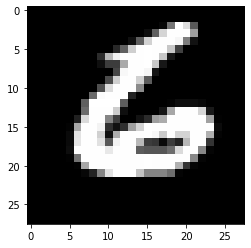

In [13]:
test_data = X_test[-1].reshape(1,28,28,1)
pred_y = model.predict(test_data)
pred_y = pred_y.argmax()

print('predict label : ',Y_test[-1])
plt.imshow(X_test[-1].reshape(28,28), cmap='gray')

## 3.2 모델 합치기(feature extractor, ANN classifier)
convolution과 maxpooling layer로 구성된 feature extractor 모델과

fully connected layer로 구성된 ANN classifier 모델을 따로 정의하고

두 모델을 합쳐서 CNN 모델을 만듬

In [15]:
def conv_maxpool_layers(n_in):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=n_in))
    model.add(Conv2D(32, (3, 3), padding='same',strides=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def fc_layers(n_out):
    model = Sequential()
    model.add(Dense(units =128, input_shape=(1568,), activation='relu'))
    model.add(Dense(units =n_out, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def CNN_(n_in, n_out):
    #각 부분 모델
    feature_extractor=conv_maxpool_layers(n_in)
    feature_extractor.trainable=True
    ann_classifier = fc_layers(n_out)
    ann_classifier.trainable=True
    
    #두 모델을 합쳐 새로운 모델 정의
    x = Input(shape=n_in)
    feature = feature_extractor(x)
    y = ann_classifier(feature)
    model = Model(inputs = x, outputs = y)
    
    #model = Sequential()
    #model.add(feature_extractor)
    #model.add(ann_classifier)
    
    return model

In [16]:
model = CNN_(n_in, n_out)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1568)              4800      
_________________________________________________________________
sequential_2 (Sequential)    (None, 10)                202122    
Total params: 206,922
Trainable params: 206,922
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_split=0.2)

Epoch 1/20
375/375 [==============================] - 3s 9ms/step - loss: 0.6775 - accuracy: 0.9110 - val_loss: 0.1012 - val_accuracy: 0.9707
Epoch 2/20
375/375 [==============================] - 3s 8ms/step - loss: 0.0663 - accuracy: 0.9793 - val_loss: 0.0693 - val_accuracy: 0.9808
Epoch 3/20
375/375 [==============================] - 3s 8ms/step - loss: 0.0375 - accuracy: 0.9879 - val_loss: 0.0684 - val_accuracy: 0.9808
Epoch 4/20
375/375 [==============================] - 3s 8ms/step - loss: 0.0257 - accuracy: 0.9914 - val_loss: 0.0687 - val_accuracy: 0.9819
Epoch 5/20
375/375 [==============================] - 3s 8ms/step - loss: 0.0168 - accuracy: 0.9943 - val_loss: 0.0743 - val_accuracy: 0.9819
Epoch 6/20
375/375 [==============================] - 3s 8ms/step - loss: 0.0151 - accuracy: 0.9947 - val_loss: 0.0822 - val_accuracy: 0.9835
Epoch 7/20
375/375 [==============================] - 3s 8ms/step - loss: 0.0168 - accuracy: 0.9944 - val_loss: 0.0864 - val_accuracy: 0.9803
Epoch 

### Image data augmentation
케라스에서는 ImageDataGenerate 함수로 Data augmentation 기능을  제공

https://keras.io/preprocessing/image/#imagedatagenerator-class

In [19]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array

In [19]:
datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 10, # 회전
    zoom_range = 0.1, # 확대 축소
    width_shift_range = 0.1, # 수평 이동
    height_shift_range = 0.1, # 수직 이동
    horizontal_flip = False, # 수평 반전
    vertical_flip = False # 수직 반전
)

datagen.fit(X_train)

ImageDataGenerator로 생성하는 데이터를 학습하기 위해서는 fit() 함수가 아닌 fit_generator() 함수를 사용해야함

In [20]:
model = CNN_(n_in, n_out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit_generator(datagen.flow(X_train[:-10000], Y_train[:-10000], batch_size = 1000),
                   epochs = 20,
                   validation_data = (X_train[-10000:], Y_train[-10000:]),
                   steps_per_epoch = 100, #epoch당 datagen을 호출하는 횟수
                   verbose = 1)

#총 데이터셋의 크기는 batch_size*steps_per_epoch

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
100/100 [==============================] - 24s 237ms/step - loss: 1.9146 - accuracy: 0.6847 - val_loss: 0.2029 - val_accuracy: 0.9383
Epoch 2/20
100/100 [==============================] - 22s 222ms/step - loss: 0.2410 - accuracy: 0.9248 - val_loss: 0.1127 - val_accuracy: 0.9668
Epoch 3/20
100/100 [==============================] - 22s 221ms/step - loss: 0.1489 - accuracy: 0.9537 - val_loss: 0.0754 - val_accuracy: 0.9788
Epoch 4/20
100/100 [==============================] - 22s 221ms/step - loss: 0.1151 - accuracy: 0.9646 - val_loss: 0.0705 - val_accuracy: 0.9782
Epoch 5/20
100/100 [==============================] - 24s 243ms/step - loss: 0.0956 - accuracy: 0.9704 - val_loss: 0.0602 - val_accuracy: 0.9827
Epoch 6/20
100/100 [==============================] - 25s 246ms/step - loss: 0.0809 - accuracy: 0.9745 - val_loss: 0.0540 - val_accuracy: 0.9848
Epoch 7/20
100/100 [==============================] - 

## 3.3 Transfer learning

CIFAR-10 데이터셋은 아래와 같이 총 10개의 label로 이루어진 이미지 분류를 위한 데이터셋이다.

airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

각각의 레이블마다 32×32 크기 이미지인 50,000개의 training 데이터셋, 10,000개의 test 데이터셋이 존재하고, 결과적으로 총 60,000개의 32×32 크기의 이미지로 데이터셋이 구성되어 있다.

mnist와 다르게 3개의 channel을 가지고 있다.

## (1) 데이터셋 준비

In [195]:
(X_train, Y_train), (X_test, Y_test) = datasets.cifar10.load_data()
print(X_train.shape, Y_train.shape)

(50000, 32, 32, 3) (50000, 1)


label :  [6]


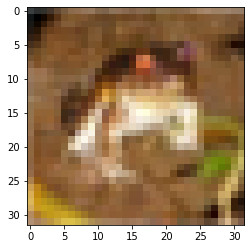

In [196]:
print('label : ',Y_train[0])
plt.imshow(X_train[0])

In [197]:
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)

print(X_train.shape, Y_train.shape)

(50000, 32, 32, 3) (50000, 10)


## (2) 모델링 <Transfer learning>
    
사용가능 네트워크 :
https://keras.io/api/applications/

In [199]:
from keras.applications.vgg16 import VGG16, preprocess_input

In [200]:
base_model = VGG16(weights='imagenet', input_shape=(32,32,3), include_top=False)
# base_model = VGG16(weights=None, input_shape=(32,32,3), include_top=False)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [201]:
import seaborn as sns

block1_conv1


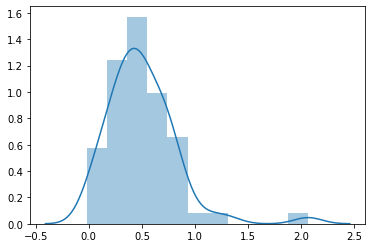

In [202]:
print(base_model.layers[1].name)
sns.distplot(base_model.layers[1].weights[1].numpy())

In [203]:
x = base_model.output
x = Flatten()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(Y_train.shape[1], activation='softmax')(x)

In [204]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [205]:
# first: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

In [206]:
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0  

## (3) 모델의 학습과정 설정

In [207]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## (4) 모델 학습시키기

In [208]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_split=0.2)

Epoch 1/20
313/313 [==============================] - 7s 22ms/step - loss: 3.4638 - accuracy: 0.4574 - val_loss: 1.5913 - val_accuracy: 0.4980
Epoch 2/20
313/313 [==============================] - 7s 21ms/step - loss: 1.2735 - accuracy: 0.5827 - val_loss: 1.3661 - val_accuracy: 0.5667
Epoch 3/20
313/313 [==============================] - 7s 21ms/step - loss: 1.0518 - accuracy: 0.6460 - val_loss: 1.3826 - val_accuracy: 0.5735
Epoch 4/20
313/313 [==============================] - 7s 21ms/step - loss: 0.9263 - accuracy: 0.6864 - val_loss: 1.4147 - val_accuracy: 0.5867
Epoch 5/20
313/313 [==============================] - 6s 21ms/step - loss: 0.8327 - accuracy: 0.7160 - val_loss: 1.5383 - val_accuracy: 0.5764
Epoch 6/20
313/313 [==============================] - 6s 20ms/step - loss: 0.7554 - accuracy: 0.7420 - val_loss: 1.5935 - val_accuracy: 0.5823
Epoch 7/20
313/313 [==============================] - 7s 21ms/step - loss: 0.6822 - accuracy: 0.7650 - val_loss: 1.6992 - val_accuracy: 0.5818

## (5) 모델 평가하기

In [209]:
loss_and_accuracy = model.evaluate(X_test, Y_test, batch_size=128)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0],loss_and_accuracy[1]))

79/79 [==============================] - 1s 16ms/step - loss: 3.5897 - accuracy: 0.5711
loss : 3.5897, accruracy : 0.5711
